In [1]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping



from keras.applications import ResNet50, DenseNet201, densenet

import numpy as np
import matplotlib.pyplot as plt


import pandas as pd

In [2]:
train_datagen = train_path = "data/train"
valid_datagen = valid_path = "data/valid"
test_datagen = test_path = "data/test"




In [3]:
image_shape = (305, 430, 3)
N_CLASSES = 4
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


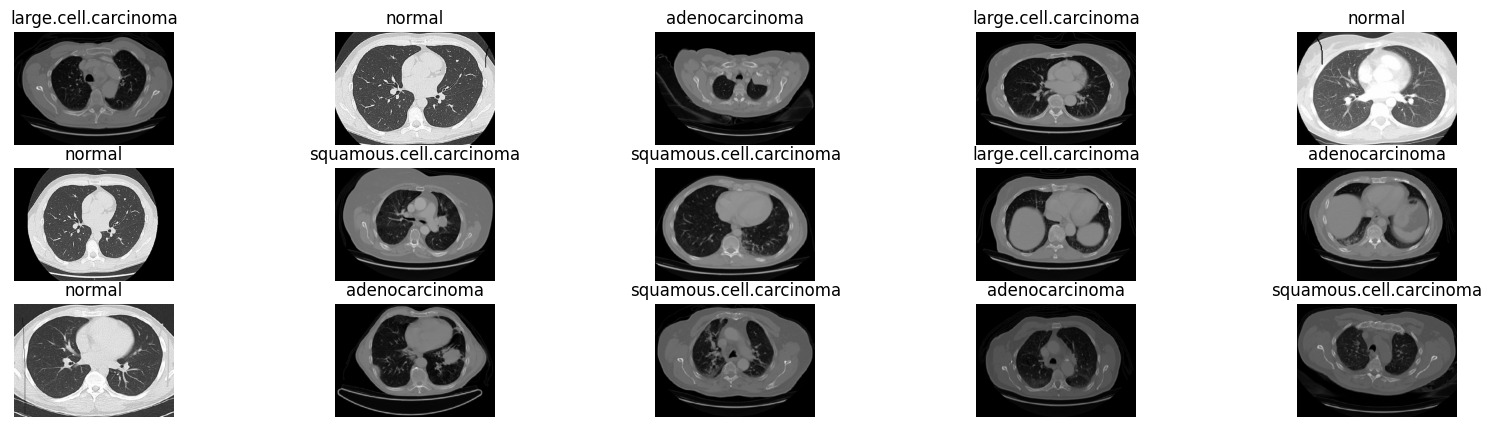

In [4]:
class_names=list(test_generator.class_indices.keys())
print(class_names)

fig = plt.figure(figsize=(20,5))

image_batch,label_batch = test_generator[1]
for i in range(15):
    ax = fig.add_subplot(3,5,i+1,xticks = [], yticks = [])
    ax.imshow(image_batch[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label_batch[i])])


In [5]:
first_model = Sequential([
  Conv2D(8, 2, padding='same', activation='relu', input_shape = image_shape), #feature extraction
  MaxPooling2D(2),          #spatial dimension
  Conv2D(16, 2, padding='same', activation='relu'),
  MaxPooling2D(2),

  Dropout(0.4),           # reduce the param weight of 1 neuron
  Flatten(),              #2d to 1d
  Dense(256, activation='relu'),    #learn complex patterns
  Dropout(0.4),
  Dense(4, activation='softmax')
])
first_model.summary()

c:\Users\DarkCarnage\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 305, 430, 8)    │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 152, 215, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 152, 215, 16)   │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 76, 107, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 76, 107, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 130112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,310,588 (127.07 MB)

 Trainable params: 33,310,588 (127.07 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
checkpointer = ModelCheckpoint('chestmodel.keras',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)

first_model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = first_model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 20,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

c:\Users\DarkCarnage\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/20


c:\Users\DarkCarnage\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - acc: 0.3300 - loss: 1.3476
Epoch 1: val_loss improved from inf to 1.23870, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 346s 11s/step - acc: 0.3330 - loss: 1.3450 - val_acc: 0.4306 - val_loss: 1.2387
Epoch 2/20


c:\Users\DarkCarnage\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.23870
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 909ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.4306 - val_loss: 1.2516
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - acc: 0.4656 - loss: 1.1942
Epoch 3: val_loss did not improve from 1.23870
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - acc: 0.4652 - loss: 1.1933 - val_acc: 0.4444 - val_loss: 1.2398
Epoch 4/20

Epoch 4: val_loss improved from 1.23870 to 1.20563, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 446ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.4444 - val_loss: 1.2056
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.4900 - loss: 1.1606
Epoch 5: val_loss improved from 1.20563 to 1.14163, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - acc: 0.4889 - loss: 1.1603 - val_acc: 0.5000 - val_loss: 1.1416
Epoch 6/20

Epoch 6: val_loss improved from 1.14163 to 1.13324, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━

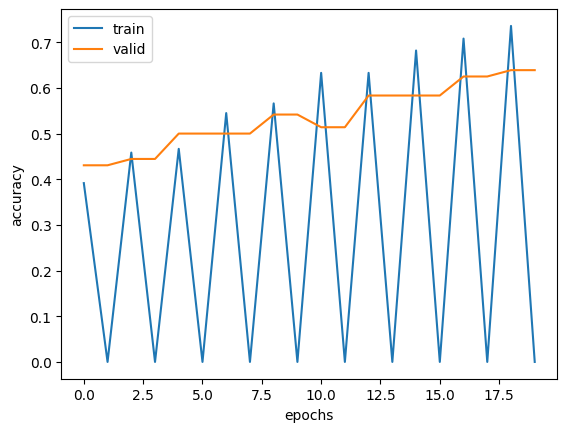

In [7]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [8]:
result = first_model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.4976 - loss: 1.0703


In [9]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [10]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))  # transL
# fine tuning by freezing layers other than 5th block

for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

In [11]:
densenet_model = Sequential()
densenet_model.add(dense_model)   # adds pre trained densenet201 model
densenet_model.add(Flatten())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(N_CLASSES, activation='softmax'))
densenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ ?                      │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 6,978,560 (26.62 MB)

 Non-trainable params: 11,343,424 (43.27 MB)

In [12]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
densenet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

checkpointer = ModelCheckpoint(filepath='./chestmodel-DenseNet201.keras',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [13]:
history_dense = densenet_model.fit(train_generator,
                                steps_per_epoch = 20,
                                epochs = 50,
                                verbose = 1,
                                validation_data = valid_generator,
                                callbacks = [checkpointer, early_stopping])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - acc: 0.3677 - loss: 1.3753 
Epoch 1: val_loss improved from inf to 1.36550, saving model to ./chestmodel-DenseNet201.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 1289s 52s/step - acc: 0.3718 - loss: 1.3660 - val_acc: 0.2500 - val_loss: 1.3655
Epoch 2/50

Epoch 2: val_loss did not improve from 1.36550
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.2500 - val_loss: 1.3839
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - acc: 0.7155 - loss: 0.7184 
Epoch 3: val_loss improved from 1.36550 to 1.22270, saving model to ./chestmodel-DenseNet201.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 868s 41s/step - acc: 0.7164 - loss: 0.7171 - val_acc: 0.3611 - val_loss: 1.2227
Epoch 4/50

Epoch 4: val_loss did not improve from 1.22270
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.3611 - val_loss: 1.2470
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - acc: 0.8382 - loss: 0.6109 
Epoch 5

KeyboardInterrupt: 

In [14]:
plt.plot(history_dense.history['acc'], label = 'train',)
plt.plot(history_dense.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

NameError: name 'history_dense' is not defined

In [ ]:
dns_result = densenet_model.evaluate(test_generator)

10/10 [==============================] - 260s 26s/step - loss: 0.6689 - acc: 0.7587
